In [3]:
# =========================================
# ✅ MobileNetV2 Face Recognition (Better Accuracy)
# SAME MODEL: MobileNetV2 (Transfer Learning + Fine-tuning)
# =========================================

# --- 1) Mount Drive (if using Colab) ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from PIL import Image
import shutil
import random

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [5]:
DATA_DIR = "/content/data/data"
BASE_DIR = "/content/split_data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Increased for transfer learning
EPOCHS = 100

In [6]:
data_dir = "/content/drive/MyDrive/data"  #  Assuming a shortcut to the shared folder is in My Drive
print(" Using dataset directory:", data_dir)

 Using dataset directory: /content/drive/MyDrive/data


In [7]:
if not os.path.exists(data_dir):
    print(f" Error: The directory '{data_dir}' does not exist. Please ensure you have a folder named 'data' (or a shortcut to your shared folder named 'data') in your Google Drive's 'MyDrive' and that Google Drive is properly mounted.")
    print("You might need to create this folder or check the path.")
else:
    print(" Classes found:", os.listdir(data_dir))

 Classes found: ['23-50066-1', '22-49783-3', '22-49800-3', '22-49745-3', '22-49824-3', '23-50254-1', '22-49843-3', '22-49861-3', '23-50689-1', '22-49975-3', '22-49575-3', '22-49068-3', '22-49167-3', '22-49196-3', '22-49621-3', '22-49609-3', '22-49507-3', '22-49619-3', '22-49355-3', '22-49370-3', '22-48091-2', '22-48133-2', '22-48833-3', '22-49037-3', '22-48569-3', '22-48055-2', '22-48205-2', '22-48023-2', '22-48039-2', '22-48582-3', '22-47898-2', '22-47925-2', '22-47884-2', '22-47294-1', '22-47966-2', '22-47968-2', '22-47384-2', '22-47876-2', '22-47894-2', '22-47888-2', '22-47027-1', '22-46880-1', '22-46983-1', '22-46342-1', '22-46586-1', '22-46536-1', '22-47180-1', '22-46590-1', '22-46887-1', '22-46840-1', '22-46275-1', '21-45902-3', '22-46139-1', '22-46258-1', '22-46293-1', '22-46156-1', '22-46141-1']


In [8]:
broken_files = []
for cls in os.listdir(data_dir): # Changed DATA_DIR to data_dir
    cls_path = os.path.join(data_dir, cls) # Changed DATA_DIR to data_dir
    if not os.path.isdir(cls_path):
        continue

    for f in os.listdir(cls_path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(cls_path, f)
            try:
                img = Image.open(path)
                img.verify()
                img = Image.open(path)
                img.load()
            except:
                broken_files.append(path)

print(f"✓ Broken files found: {len(broken_files)}")
for f in broken_files:
    os.remove(f)
print("✓ All broken files removed")

✓ Broken files found: 0
✓ All broken files removed


In [9]:
valid_classes = []
class_image_counts = {}

for cls in os.listdir(data_dir): # Changed DATA_DIR to data_dir
    cls_path = os.path.join(data_dir, cls) # Changed DATA_DIR to data_dir
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    class_image_counts[cls] = len(images)

    if len(images) >= 9:  # Minimum 9 images (6 train, 2 val, 1 test)
        valid_classes.append(cls)

valid_classes = sorted(valid_classes)
NUM_CLASSES = len(valid_classes)

print(f"✓ Total folders found: {len(class_image_counts)}")
print(f"✓ Valid classes (>=9 images): {NUM_CLASSES}")

if NUM_CLASSES < 2:
    raise ValueError("ERROR: Not enough valid classes. Need at least 9 images per student!")

# Show distribution
print("\nImage count distribution:")
counts = sorted(class_image_counts.values(), reverse=True)
print(f"  Maximum images: {counts[0]}")
print(f"  Minimum images: {counts[-1]}")
print(f"  Average images: {np.mean(counts):.1f}")

✓ Total folders found: 57
✓ Valid classes (>=9 images): 31

Image count distribution:
  Maximum images: 60
  Minimum images: 0
  Average images: 11.1


In [10]:
random.seed(42)

if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(BASE_DIR, split), exist_ok=True)

final_classes = []

for cls in valid_classes:
    cls_path = os.path.join(data_dir, cls) # Changed DATA_DIR to data_dir

    images = [f for f in os.listdir(cls_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    random.shuffle(images)
    n = len(images)

    # Smarter split for small datasets
    if n >= 12:
        train_count = max(6, int(n * 0.65))
        val_count = max(2, int(n * 0.20))
    else:
        train_count = max(6, n - 3)
        val_count = max(1, (n - train_count) // 2)

    train_end = train_count
    val_end = train_end + val_count

    split_map = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    # Skip if any split is empty
    if any(len(imgs) == 0 for imgs in split_map.values()):
        continue

    final_classes.append(cls)

    for split, imgs in split_map.items():
        split_cls_dir = os.path.join(BASE_DIR, split, cls)
        os.makedirs(split_cls_dir, exist_ok=True)

        for img in imgs:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(split_cls_dir, img)
            )

NUM_CLASSES = len(final_classes)
print(f"✓ Successfully split {NUM_CLASSES} classes")

✓ Successfully split 31 classes


In [11]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=30,
    fill_mode="nearest"
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    BASE_DIR + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb"
)

val_data = val_test_gen.flow_from_directory(
    BASE_DIR + "/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = val_test_gen.flow_from_directory(
    BASE_DIR + "/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_data.num_classes

print(f"✓ Dataset loaded successfully!")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Training samples: {train_data.samples}")
print(f"  Validation samples: {val_data.samples}")
print(f"  Test samples: {test_data.samples}")

Found 392 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 114 images belonging to 31 classes.
✓ Dataset loaded successfully!
  Classes: 31
  Training samples: 392
  Validation samples: 112
  Test samples: 114


In [12]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model initially
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

print("✓ Model architecture created")
print(f"✓ Using MobileNetV2 pretrained on ImageNet")
print(f"✓ Base model frozen: {not base_model.trainable}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Model architecture created
✓ Using MobileNetV2 pretrained on ImageNet
✓ Base model frozen: True


In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled")
model.summary()


✓ Model compiled


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,060,319 (11.67 MB)

 Trainable params: 798,751 (3.05 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_face_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [15]:
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0865 - loss: 3.7942
Epoch 1: val_accuracy improved from -inf to 0.46429, saving model to best_face_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.0890 - loss: 3.7826 - val_accuracy: 0.4643 - val_loss: 2.2297 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.3166 - loss: 2.5981
Epoch 2: val_accuracy improved from 0.46429 to 0.59821, saving model to best_face_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 866ms/step - accuracy: 0.3184 - loss: 2.5923 - val_accuracy: 0.5982 - val_loss: 1.6623 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.4629 - loss: 2.0233
Epoch 3: val_accuracy improved from 0.59821 to 0.76786, saving model to best_face_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 913ms/step - accuracy: 0.4633 - loss: 2.0208 - val_accuracy: 0.7679 - val_loss: 1.2374 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70

In [16]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data, verbose=1)

print(f"\n{'='*70}")
print(f"✓ TEST ACCURACY: {test_acc*100:.2f}%")
print(f"✓ TEST LOSS: {test_loss:.4f}")
print(f"{'='*70}")

if test_acc < 0.3:
    print("\n⚠ WARNING: Accuracy is still low. This means:")
    print("  1. You need MORE images per student (aim for 30-50)")
    print("  2. Images should be clear, well-lit faces")
    print("  3. Try different angles and expressions")
    print("  4. Ensure consistent image quality")

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9331 - loss: 0.2935

✓ TEST ACCURACY: 92.98%
✓ TEST LOSS: 0.2843


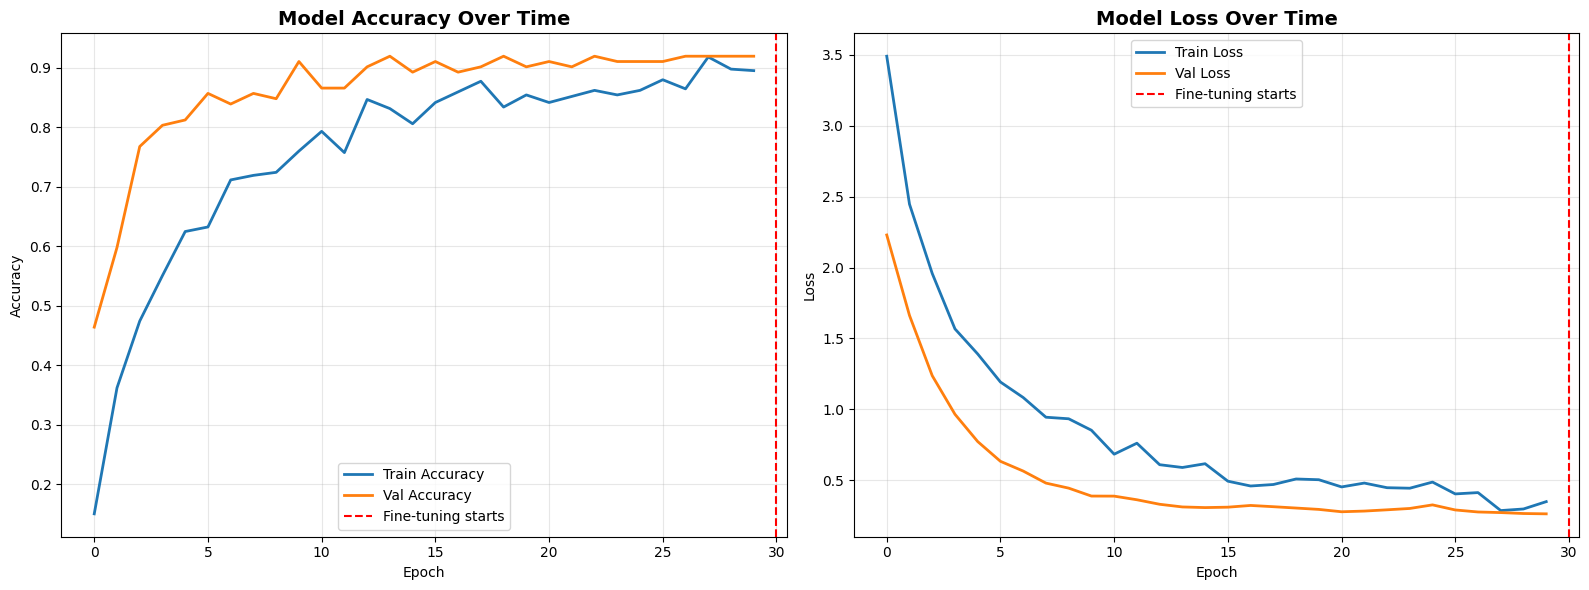

In [18]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.axvline(x=30, color='red', linestyle='--', label='Fine-tuning starts')
plt.title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history1.history['val_loss'], label='Val Loss', linewidth=2)
plt.axvline(x=30, color='red', linestyle='--', label='Fine-tuning starts')
plt.title('Model Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

✓ Class mapping created and saved
✓ Total classes: 31

Sample mappings (index -> student ID):
  0 -> 22-46139-1
  1 -> 22-46141-1
  2 -> 22-46156-1
  3 -> 22-46258-1
  4 -> 22-46275-1

PREDICTION SAMPLES - Face Recognition by Student ID


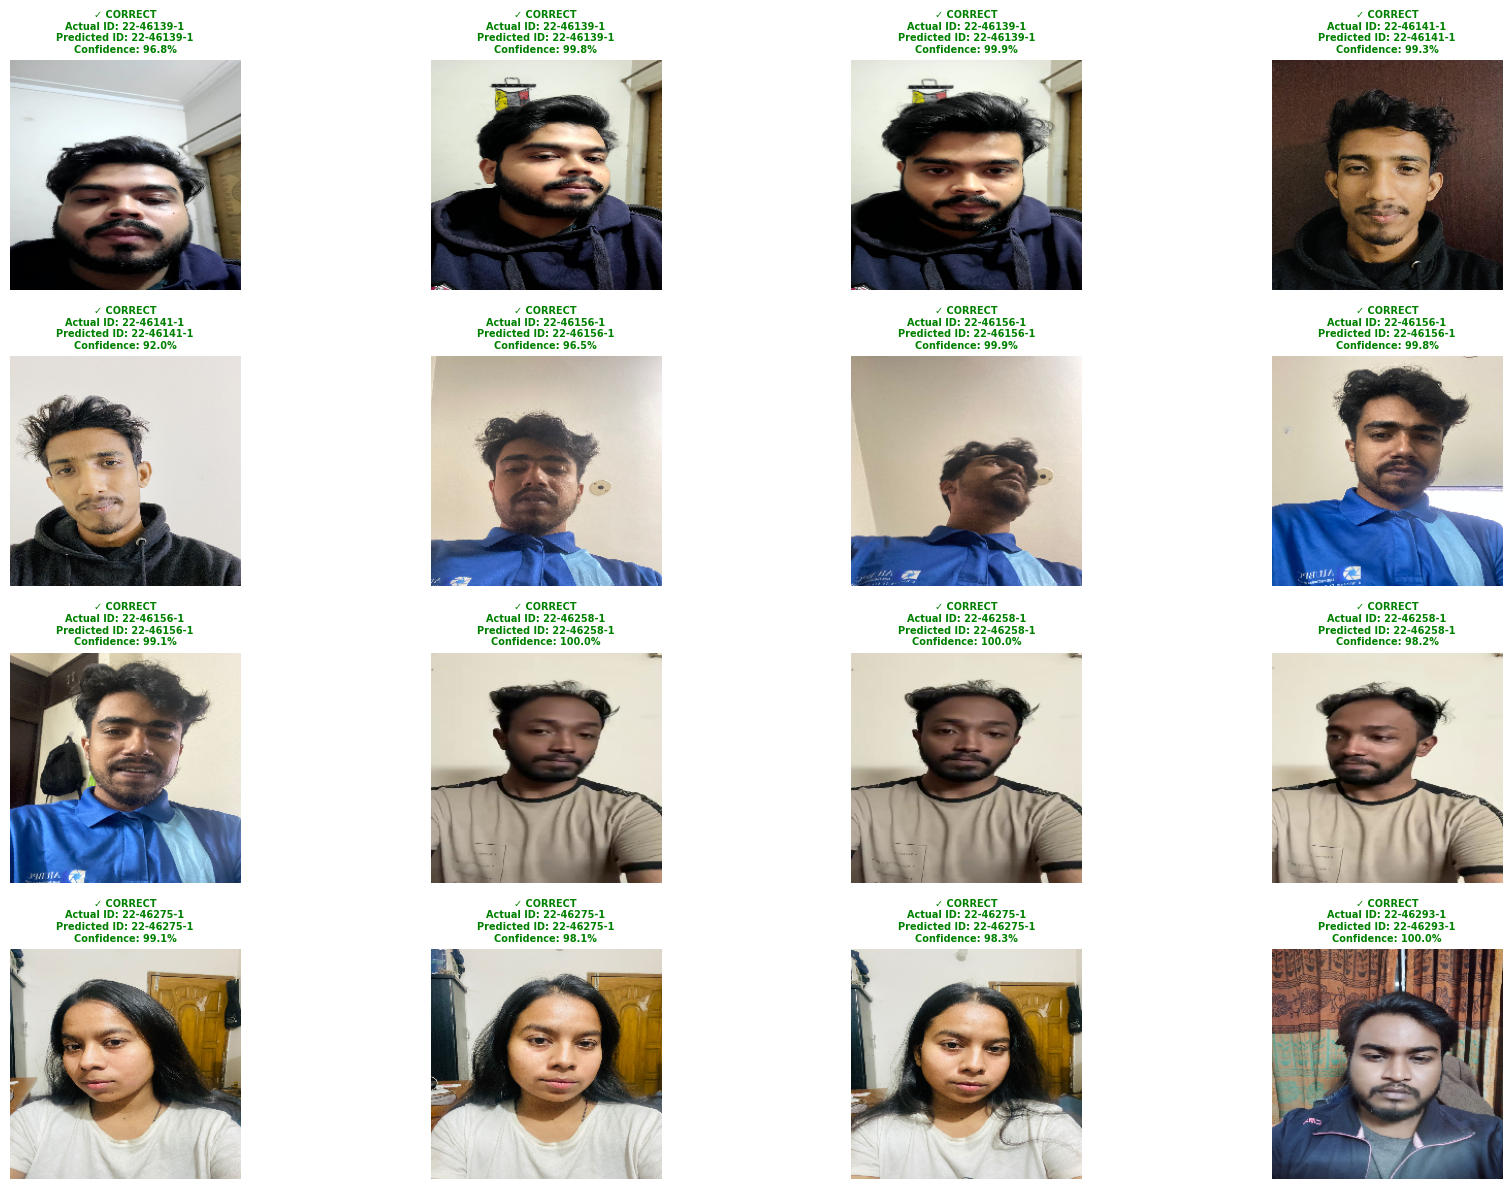


Batch Results: 16/16 correct = 100.00%

✓ CORRECT PREDICTIONS:
  Student ID: 22-46139-1 - Confidence: 96.8%
  Student ID: 22-46139-1 - Confidence: 99.8%
  Student ID: 22-46139-1 - Confidence: 99.9%


In [23]:
# =============================================================================
# CREATE CLASS MAPPING (RUN THIS FIRST!)
# =============================================================================
import json

class_indices = train_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Save it
with open('class_mapping.json', 'w') as f:
    json.dump(index_to_class, f, indent=2)

print("✓ Class mapping created and saved")
print(f"✓ Total classes: {len(class_indices)}")
print(f"\nSample mappings (index -> student ID):")
for i in list(index_to_class.keys())[:5]:
    print(f"  {i} -> {index_to_class[i]}")

# =============================================================================
# DETAILED PREDICTIONS ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("PREDICTION SAMPLES - Face Recognition by Student ID")
print("="*70)

# Reset the test data generator to start from beginning
test_data.reset()

test_images, test_labels = next(test_data)
predictions = model.predict(test_images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

plt.figure(figsize=(18, 12))
num_samples = min(16, len(test_images))

correct_count = 0

for i in range(num_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')

    # Get student IDs (folder names)
    pred_student_id = index_to_class[predicted_classes[i]]
    true_student_id = index_to_class[true_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100

    is_correct = pred_student_id == true_student_id
    if is_correct:
        correct_count += 1

    color = 'green' if is_correct else 'red'
    status = '✓ CORRECT' if is_correct else '✗ WRONG'

    plt.title(f"{status}\nActual ID: {true_student_id}\nPredicted ID: {pred_student_id}\nConfidence: {confidence:.1f}%",
              color=color, fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

batch_accuracy = correct_count / num_samples * 100
print(f"\n{'='*70}")
print(f"Batch Results: {correct_count}/{num_samples} correct = {batch_accuracy:.2f}%")
print(f"{'='*70}")

# Show some correct predictions
print("\n✓ CORRECT PREDICTIONS:")
for i in range(min(3, num_samples)):
    if predicted_classes[i] == true_classes[i]:
        print(f"  Student ID: {index_to_class[true_classes[i]]} - Confidence: {predictions[i][predicted_classes[i]]*100:.1f}%")

# Show some incorrect predictions if any
wrong_indices = [i for i in range(num_samples) if predicted_classes[i] != true_classes[i]]
if wrong_indices:
    print("\n✗ INCORRECT PREDICTIONS:")
    for i in wrong_indices[:3]:
        print(f"  True ID: {index_to_class[true_classes[i]]} -> Predicted as: {index_to_class[predicted_classes[i]]} (Conf: {predictions[i][predicted_classes[i]]*100:.1f}%)")

In [20]:
# ================================
# SAVE MODEL (KERAS 3 SAFE FORMAT)
# ================================

import tensorflow as tf
import json
import numpy as np

# 🔹 STEP 1: Force model to build (VERY IMPORTANT)
dummy_input = np.zeros((1, 224, 224, 3), dtype=np.float32)
_ = model(dummy_input)

# 🔹 STEP 2: Save model directly
model.save("face_recognition_mobilenet.h5")
print("✓ Model saved as face_recognition_mobilenet.h5")

# 🔹 STEP 3: Save class mapping
with open("class_mapping.json", "w") as f:
    json.dump(index_to_class, f, indent=2)
print("✓ Class mapping saved")

print("\nDONE ✅")


✓ Model saved as face_recognition_mobilenet.h5
✓ Class mapping saved

DONE ✅
